In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.optim

# CODE FILES HERE
from models.cvae.cvae import Encoder, Decoder, Cvae, PATH
from solver import Solver
from dataloader import DataLoader
from plot import plot_losses, plot_gaussian_distributions, plot_rl_kl, plot_latent_space, plot_latent_space_no_labels, \
plot_latent_manifold, plot_faces_grid, plot_faces_samples_grid

# SETTINGS HERE
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [3]:
# Choose the dataset and tune hyperparameters here!
dataset = "MNIST"
batch_size = 128
optimizer = torch.optim.Adam

if dataset == "MNIST":
    cvae_mode = True
    epochs = 20
    hidden_dim = 500
    z_dim = 2
    warmup_epochs = 0
    beta = 1 if z_dim == 2 else 1
    step_lr = False
    step_config = {
        "step_size" : 200,
        "gamma" : 0.1 # or 0.75
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": 1e-4
    }

In [4]:
data_loader = DataLoader(PATH, batch_size, dataset, z_dim)
model = Cvae(data_loader.input_dim, hidden_dim, z_dim, data_loader.n_classes)

In [5]:
solver = Solver(model, data_loader, optimizer, cvae_mode, z_dim, epochs, step_lr, step_config, optim_config, warmup_epochs, beta, batch_size)
solver.main()

+++++ START RUN +++++
20 1 1 0 2 False 2 20 128
1
====> Epoch: 1 train set loss avg: 459.8318
====> Test set loss avg: 403.1823
56.26522183418274 seconds for epoch 1
1
====> Epoch: 2 train set loss avg: 352.2902
====> Test set loss avg: 323.9431
65.0082426071167 seconds for epoch 2
1
====> Epoch: 3 train set loss avg: 287.3514
====> Test set loss avg: 274.8969
86.42319989204407 seconds for epoch 3
1
====> Epoch: 4 train set loss avg: 245.1690
====> Test set loss avg: 239.9918
83.07611274719238 seconds for epoch 4
1
====> Epoch: 5 train set loss avg: 216.4102
====> Test set loss avg: 217.0750
79.21648645401001 seconds for epoch 5
1
====> Epoch: 6 train set loss avg: 196.1545
====> Test set loss avg: 201.6499
73.87073922157288 seconds for epoch 6
1
====> Epoch: 7 train set loss avg: 181.5884
====> Test set loss avg: 188.7961
80.60341167449951 seconds for epoch 7
1
====> Epoch: 8 train set loss avg: 170.7724
====> Test set loss avg: 179.8760
68.52440977096558 seconds for epoch 8
1
====> E

In [ ]:
# Insert name of model here if want to load a model, e.g. solver.save_model_dir + "/VAE_MNIST_train_loss=151.39_z=2.pt"
#solver = torch.load(solver.save_model_dir + "/VAE_MNIST_train_loss=97.15_z=20.pt")
#solver.model.eval()

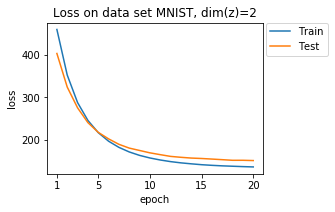

In [7]:
# Plotting train and test losses for all epochs
plot_losses(solver, 4)

epoch: 1, mu(z): 0.0066, stddev(z): 0.9649, var(z): 0.9310, var(mu(z)): 0.8454 E[var(q(z|x)]: 0.0895
epoch: 5, mu(z): -0.0009, stddev(z): 1.0061, var(z): 1.0123, var(mu(z)): 0.9903 E[var(q(z|x)]: 0.0191
epoch: 10, mu(z): -0.0007, stddev(z): 0.9979, var(z): 0.9959, var(mu(z)): 0.9785 E[var(q(z|x)]: 0.0144
epoch: 20, mu(z): -0.0008, stddev(z): 0.9995, var(z): 0.9990, var(mu(z)): 0.9841 E[var(q(z|x)]: 0.0123


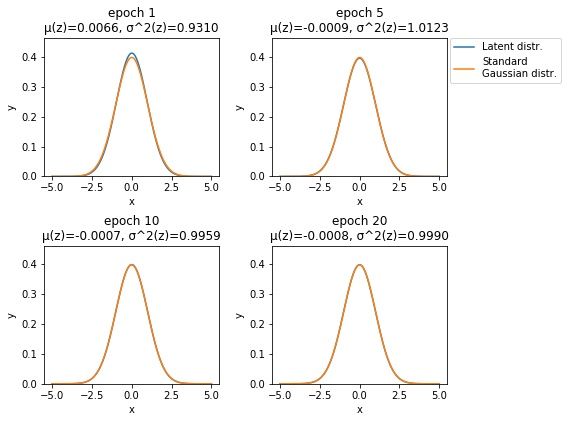

In [8]:
plot_gaussian_distributions(solver)

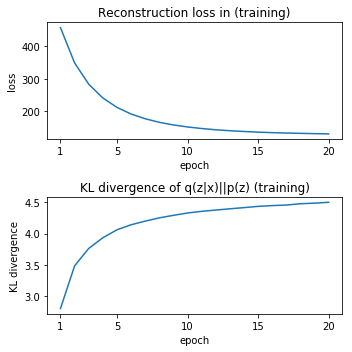

In [9]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
DEBUG = 0
if DEBUG:
    for epoch, train_loss, test_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
                             solver.train_loss_history["train_loss_acc"], \
                             solver.test_loss_history, \
                             solver.train_loss_history["recon_loss_acc"], \
                             solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(
            epoch, train_loss, test_loss, rl, kl))
        print("overfitting: {:.2f}".format(abs(test_loss-train_loss)))
plot_rl_kl(solver, 4)

In [ ]:
# visualize q(z) (latent space z)
if solver.z_dim == 2:
    if solver.loader.dataset == "FF":
        plot_latent_space_no_labels(solver)
    else:
        plot_latent_space(solver)
else:
    print("Plot of latent space not possible as dimension of z is not 2")

In [ ]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if solver.z_dim == 2:
    if solver.loader.dataset == "MNIST":
        plot_latent_manifold(solver, "bone")
    if solver.loader.dataset == "LFW" or solver.loader.dataset == "FF":
        plot_latent_manifold(solver, "gray", n=10, fig_size=(10, 8))
else:
    print("Plot is not possible as dimension of z is not 2")

In [ ]:
# plots real faces and in grid samples
if solver.loader.dataset == "LFW" or solver.loader.dataset == "FF":
    plot_faces_grid(225, 15, solver)
    plot_faces_samples_grid(225, 15, solver)

In [6]:
last_train_loss = solver.train_loss_history["train_loss_acc"][-1]
torch.save(solver, solver.save_model_dir + "/CVAE_" + solver.loader.dataset + "_train_loss=" + "{0:.2f}".format(last_train_loss) + "_z=" + str(solver.z_dim) + ".pt")

PicklingError: Can't pickle <class 'solver.Solver'>: it's not the same object as solver.Solver